In [1]:
from fastai.vision.all import *
import fastprogress
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2, json, ast, timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.config.model_config import efficientdet_model_param_dict
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

from torch import optim
import kornia as K
from map_boxes import mean_average_precision_for_boxes
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')

In [2]:
pot_dir = Path('/mnt/data/det/potholes')
mask_dir = Path('/mnt/data/det/masks')
circuit_dir = Path('/mnt/data/circuits')

In [3]:
def extract_coords(boxes):
    y_min = int(boxes.find("bndbox/ymin").text)
    x_min = int(boxes.find("bndbox/xmin").text)
    y_max = int(boxes.find("bndbox/ymax").text)
    x_max = int(boxes.find("bndbox/xmax").text)
    return x_min, y_min, x_max, y_max

def read_annot(file_name):
    bbox = []
    labels = []
    
    annot_path = file_name
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        x_min, y_min, x_max, y_max = extract_coords(boxes)
        label = boxes.find('name').text
        bbox.append([x_min, y_min, x_max, y_max])
        labels.append(label)
    df = pd.DataFrame(columns='label,x1,y1,x2,y2'.split(','))
    df['x1,y1,x2,y2'.split(',')] = bbox
    df['label'] = labels
    return df

def get_labels(root):
    labels = set()
    filter_xml = lambda x: str(x).endswith('.xml')
    fs = get_files(root/'annotations').filter(filter_xml)
    for f in fs:
        tree = ET.parse(f)
        root = tree.getroot()
        for boxes in root.iter('object'):
            label = boxes.find('name').text
            labels.add(label)
    return list(labels)

def proc_coco(fs):
    items = dict()
    for f in fs:
        file = ast.literal_eval(f.read_text())[0]
        o = pd.DataFrame(file['annotations'])
        f_name = file['image']
        if o.shape[0]>0:
            coords = np.array(o['coordinates'].apply(lambda x: list(x.values())).values.tolist())
            o['x1,y1,x2,y2'.split(',')] = xcycwh2xyxy(coords)
            o.drop(columns='coordinates', inplace=True)
        else:
            o = pd.DataFrame({'label': ['none'], 'x1': [0], 'y1': [0], 'x2': [1], 'y2': [1]})
        items[f.stem + '.' + f_name.split('.')[-1]] = o
    return items
      
def proc_pascal(fs, ext):
    items = dict()
    xml_dir = fs[0].parent.parent/'annotations'
    for f in fs:
        img_name = f.stem + '.xml'
        xml_file = xml_dir/img_name
        items[f.stem + ext] = read_annot(xml_file)
    return items

In [4]:
def xcycwh2xyxy(o):
    xc, yc, w, h = np.split(o, 4, axis=1)
    x1 = xc - w/2
    x2 = xc + w/2
    y1 = yc - h/2
    y2 = yc + h/2
    return np.concatenate([x1, y1, x2, y2], axis=1)

def clip_bbox(df, w, h):
    df['x1'].clip(0, w-1, inplace=True)
    df['x2'].clip(0, w, inplace=True)
    df['y1'].clip(0, h-1, inplace=True)
    df['y2'].clip(0, h, inplace=True)

In [5]:
def get_train_tfms():
    tfms = A.Compose([
                      A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
                     A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9)], p=0.9),
                     A.HorizontalFlip(p=0.5),
                     A.VerticalFlip(p=0.5),
                     A.Resize(height=512, width=512, p=1.0),
                     A.Cutout(num_holes = 8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                     ToTensorV2(p=1.0), ], p=1.0,
                     bbox_params = A.BboxParams(format= 'pascal_voc',
                                               min_area=0,
                                               min_visibility=0,
                                               label_fields=['labels'])
                    )
    return tfms

def get_valid_tfms():
    tfms = A.Compose([A.Resize(height=512, width=512, p=1.0),
                     ToTensorV2(p=1.0)], p=1.0,
                    bbox_params = A.BboxParams(format='pascal_voc',
                                              min_area=0,
                                              min_visibility=0,
                                              label_fields=['labels']))
    return tfms

In [6]:
class EffDataset(Dataset):
    def __init__(self, fs, augs):
        self.fs = fs
        self.augs = augs   
    
    @classmethod
    def from_coco(cls, root):
        cls.root = root
        filter_json = lambda x: str(x).endswith('.json')
        fs = get_files(Path(root)/'annotations').filter(filter_json)
        cls.targs = proc_coco(fs)
        c =list(sorted(pd.concat(list(cls.targs.values()))['label'].unique().tolist()))
        if 'none' in c: c.remove('none')
        cls.c = ['none'] + c
        cls.encs = {j:i for i,j in enumerate(cls.c)}
        cls.rev_encs = {j:i for i,j in cls.encs.items()}
        x_train, x_val = train_test_split(list(cls.targs.keys()), 
                                          test_size=0.2, random_state=2021)
        return cls(x_train, get_train_tfms()), cls(x_val, get_valid_tfms())
            
    @classmethod
    def from_pascal(cls, root):
        cls.root = root
        ext = (root/'images').ls()[0].suffix
        cls.targs = proc_pascal(get_image_files(root/'images'), ext)
        c = sorted(get_labels(root))
        if 'none' in c: c.remove('none')
        cls.c = ['none'] + c
        cls.encs = {j:i for i,j in enumerate(cls.c)}
        cls.rev_encs = {j:i for i,j in cls.encs.items()}
        x_train, x_val = train_test_split(list(cls.targs.keys()),
                                          test_size=0.2, random_state=2021)
        return cls(x_train, get_train_tfms()), cls(x_val, get_valid_tfms())
    
    def __len__(self): return len(self.fs)
    
    def __getitem__(self, idx):
        name = self.fs[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(self.root, 'images', name)), cv2.COLOR_BGR2RGB)
        targs = self.targs[name]
        bboxes = clip_bbox(targs, *img.shape[:-1])
        if self.augs:
            temp = {}
            bboxes = targs.loc[:, 'x1,y1,x2,y2'.split(',')]
            sample = {'image': img,
                      'bboxes': targs.loc[:, 'x1,y1,x2,y2'.split(',')].values, 
                      'labels': targs.loc[:, 'label'].map(self.encs)}
            sample = self.augs(**sample)
            img = sample['image']
            if sample['bboxes']!=[]:
                temp['bboxes'] = torch.stack(tuple(map(partial(torch.tensor, dtype=torch.float32),
                                                                zip(*sample['bboxes'])))).permute(1,0)
                temp['labels'] = torch.tensor(sample['labels'])
                temp['bboxes'][:, [0,1,2,3]] = temp['bboxes'][:, [1,0,3,2]]
            else: return img, {'bboxes': torch.ones(1, 4), 'labels': torch.ones(1)*-1}
        return img, temp

In [7]:
# train_ds, val_ds = EffDataset.from_pascal(mask_dir)
train_ds, val_ds = EffDataset.from_coco(circuit_dir)

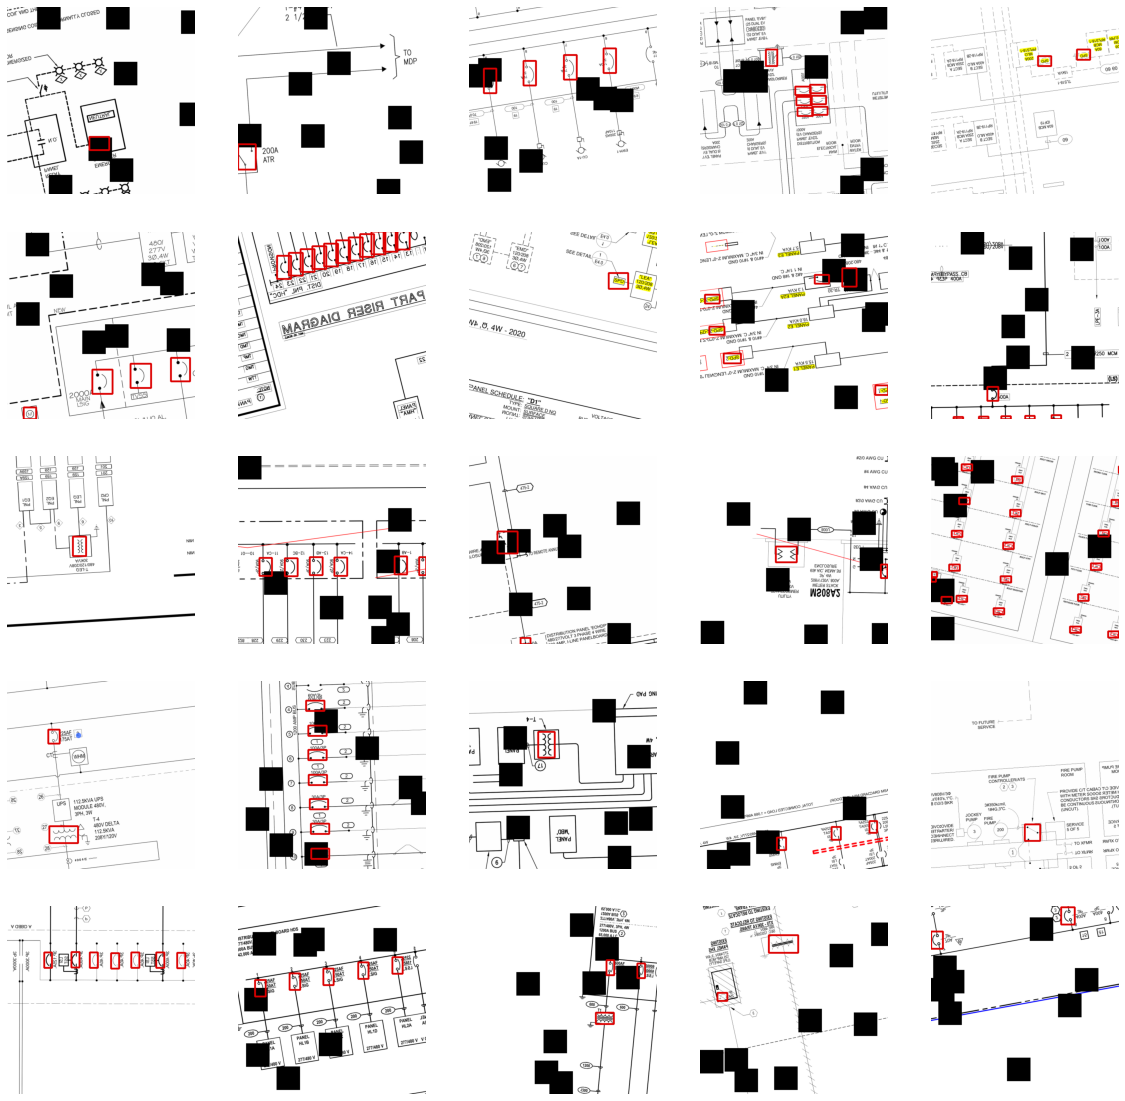

In [8]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for k, ax in enumerate(axes.ravel()):
    x, y = random.choice(train_ds)
    img = x.permute(1, 2, 0).numpy()

    for box in y['bboxes'].long().numpy():
        cv2.rectangle(img,
                      (box[1], box[0]),
                      (box[3], box[2]),
                      (220, 0, 0), 3
                     )
    ax.imshow(img)
    ax.axis('off')

In [9]:
def create_model(architecture="tf_efficientnetv2_l", nc=1, img_sz=512):
    efficientdet_model_param_dict[architecture] = dict(
        name=architecture,
        backbone_name=architecture,
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=nc,
        url='', )
    
    config = get_efficientdet_config(architecture)
    config.update({'num_classes': nc})
    config.update({'image_size': (img_sz, img_sz)})

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

In [10]:
class EffDetCB(Callback):
    def before_batch(self):
        xb = torch.stack(*self.xb).cuda()
        xb = K.normalize(xb/255.0, 
                         mean=torch.tensor((0.485, 0.456, 0.406)), 
                         std=torch.tensor((0.229, 0.224, 0.225)))
        y = self.yb[-1]
        yb = {'bbox': list(map(lambda x: x['bboxes'].cuda(), y)),
              'cls': list(map(lambda x: x['labels'].cuda(), y))}
        if not self.training:
            yb['img_scale'] = None
            yb['img_size'] = None
        self.learn.xb = (xb, yb)
        self.learn.yb = yb
        
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
dls = DataLoaders.from_dsets(train_ds, val_ds, batch_size=16, shuffle=True, pin_memory=True, num_workers=4, create_batch=collate_fn)

In [12]:
# train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, pin_memory=True, num_workers=4, collate_fn=collate_fn)
# val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, pin_memory=True, num_workers=4, collate_fn=collate_fn)
# train_dl.device = None
# val_dl.device=None
# dls = DataLoaders(train_dl, val_dl)
model = create_model('resnet34d', nc=len(train_ds.c), img_sz=512).cuda()
effdet_splitter = lambda m: L(nn.Sequential(m.model.backbone), 
                       nn.Sequential(m.model.fpn, m.model.class_net, m.model.box_net)).map(params)

In [13]:
class MapMetric(AccumMetric):
    def __init__(self, flatten=False, dim_argmax=None, activation=None, thresh=None, to_np=False,
                 invert_arg=False, name='MaP', conf_thresh=0.2, **kwargs):
        store_attr('dim_argmax,activation,thresh,flatten,to_np,conf_thresh')
        self.iou_thresh = kwargs['iou_thresh']
        
    def reset(self):
        self.targs,self.preds = [],[]
        self.count = 0
        
    def accum_values(self, preds, targs, learn=None):
        preds = [np.concatenate([np.ones((100,1))*(self.count+c), o.squeeze()], axis=1)
                 for c,o in enumerate(map(lambda x: x.numpy(), preds['detections'].detach().cpu().split(1)))]
        self.preds.extend(preds)
        bboxes = list(map(lambda x: x.cpu().numpy()[:, [1,3,0,2]], targs['bbox']))
        classes = list(map(lambda x: np.expand_dims(x.cpu().numpy(),1), targs['cls']))
        self.targs.extend([np.concatenate([np.ones_like(cl)*(self.count+i), cl, bb], axis=1) 
                           for i, (bb, cl) in enumerate(zip(bboxes, classes))])
        self.count += len(bboxes)
        
    @property
    def value(self):
        if len(self.preds) == 0: return
        pred_df = pd.DataFrame(np.concatenate(self.preds)[:, [0,6,5,1,3,2,4]], 
                               columns='ImageID,LabelName,Conf,XMin,XMax,YMin,YMax'.split(','))
        targ_df = pd.DataFrame(np.concatenate(self.targs), 
                               columns='ImageID,LabelName,XMin,XMax,YMin,YMax'.split(','))
        pred_df['LabelName'] = pred_df['LabelName'].map(train_ds.rev_encs)
        targ_df['LabelName'] = targ_df['LabelName'].map(train_ds.rev_encs)
        pred_df['ImageID,LabelName'.split(',')] = pred_df['ImageID,LabelName'.split(',')].astype(str)
        targ_df['ImageID,LabelName'.split(',')] = targ_df['ImageID,LabelName'.split(',')].astype(str)
        pred_df['XMin,XMax,YMin,YMax'.split(',')] /=512.0
        targ_df['XMin,XMax,YMin,YMax'.split(',')] /=512.0
        pred_df = pred_df[pred_df['Conf']>=self.conf_thresh]
        self.pred_df = pred_df[pred_df['LabelName'] != 'none'].reset_index(drop=True)
        self.targ_df = targ_df[targ_df['LabelName'] != 'none'].reset_index(drop=True)
        mean_ap, average_precisions = mean_average_precision_for_boxes(self.targ_df.values, self.pred_df.values, 
                                                                       verbose=False, iou_threshold=0.4)
        self.avgprec = average_precisions
        return mean_ap
    
    @property
    def name(self): return 'map'

In [14]:
from torch.cuda.amp import GradScaler,autocast
from torch.cuda.amp.grad_scaler import OptState

@delegates(GradScaler)
class EffdetMixedPrecision(Callback):
    "Mixed precision training using Pytorch's `autocast` and `GradScaler`"
    order = 10
    def __init__(self, **kwargs): self.kwargs,self.autocast = kwargs,autocast()
    def before_fit(self): self.learn.scaler,self.scales = GradScaler(**self.kwargs),L()
    def before_batch(self): self.autocast.__enter__()
    def after_pred(self):
        if self.pred['loss'].dtype==torch.float16: self.learn.pred = to_float(self.pred['loss'])
    def after_loss(self): self.autocast.__exit__()
    def before_backward(self): self.learn.loss_grad = self.scaler.scale(self.loss_grad)
    def before_step(self):
        self.skipped=True
        self.scaler.step(self)
        if self.skipped: raise CancelStepException()
        self.scales.append(self.scaler.get_scale())
    def after_step(self): self.learn.scaler.update()

    @property # pretend to be an optimizer for `GradScaler`
    def param_groups(self): return self.opt.param_groups
    def step(self, *args, **kwargs): self.skipped=False

In [15]:
def effdet_loss(*x):
    return x[0]['loss']

In [16]:
learn = Learner(dls, model,
                loss_func=effdet_loss,
                splitter=effdet_splitter,
                metrics=[MapMetric(iou_thresh=0.4, conf_thresh=0.05)],
                cbs=[EffDetCB(), GradientClip(1.0), EffdetMixedPrecision()])
learn.freeze()

SuggestedLRs(valley=0.013182567432522774)

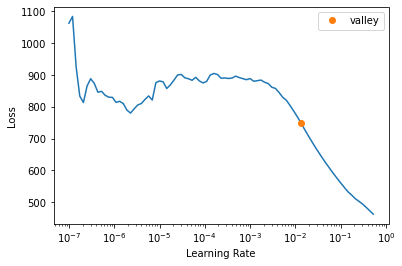

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(6, lr_max=1e-2)

epoch,train_loss,valid_loss,map,time
0,14.253831,2.411503,0.093105,01:39
1,0.713165,0.984364,0.491420,01:38
2,0.535675,0.613710,0.690890,01:39
3,0.475355,0.427831,0.856543,01:37
4,0.424463,0.349653,0.862565,01:37
5,0.388341,0.339463,0.872940,01:37


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [18]:
learn.metrics[0].avgprec

{'ats': (0.8318737719158913, 140.0),
 'breaker': (0.9326306622745677, 2549.0),
 'motor': (0.9196382738260094, 935.0),
 'spd': (0.7764536342544661, 227.0),
 'transformer': (0.8980620622319164, 253.0)}

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(16, lr_max=slice(1e-4, 1e-3), 
                    cbs=SaveModelCallback(monitor='map', comp=np.greater))

epoch,train_loss,valid_loss,map,time
0,0.388703,0.343312,0.874456,01:51
1,0.381548,0.335052,0.878444,01:51
2,0.379758,0.341251,0.880003,01:51
3,0.385138,0.328314,0.886652,01:51
4,0.377332,0.334034,0.888139,01:51
5,0.356308,0.325796,0.895137,01:51
6,0.350331,0.302512,0.899351,01:51
7,0.342085,0.306341,0.901257,01:52


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Better model found at epoch 0 with map value: 0.8744560942109774.


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Better model found at epoch 1 with map value: 0.8784437429561898.


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Better model found at epoch 2 with map value: 0.8800029695927092.


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Better model found at epoch 3 with map value: 0.8866516941617476.


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Better model found at epoch 4 with map value: 0.888139473325294.


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Better model found at epoch 5 with map value: 0.8951368660941574.


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Better model found at epoch 6 with map value: 0.8993508432949653.


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Better model found at epoch 7 with map value: 0.901256695423803.


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [20]:
learn.metrics[0].avgprec

{'ats': (0.858717063679432, 140.0),
 'breaker': (0.9429818306210379, 2549.0),
 'motor': (0.9304745567416075, 935.0),
 'spd': (0.8814703427155292, 227.0),
 'transformer': (0.9035246608483062, 253.0)}